In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import lightgbm

In [122]:
datapath = '../data/'

In [123]:
window_size = '3'

In [124]:
#gk_df = pd.read_csv(datapath+'gks_'+window_size+'.csv')
#gk_df.columns

In [126]:
gk_df = pd.read_csv(datapath+'gks_'+window_size+'.csv')
def_df = pd.read_csv(datapath+'defs_'+window_size+'.csv')
fwd_df = pd.read_csv(datapath+'fwds_'+window_size+'.csv')
mid_df = pd.read_csv(datapath+'mids_'+window_size+'.csv')

keep = ['assists', 'clean_sheets', 'minutes', 'ict_index',
       'creativity', 'goals_conceded', 'goals_scored', 'penalties_missed',
       'influence', 'penalties_saved', 'red_cards', 'saves', 'threat', 'total_points',
       'yellow_cards', 'was_home','opponent_team', 'Target_Output']

gk_df, def_df, fwd_df, mid_df = gk_df[keep], def_df[keep], fwd_df[keep], mid_df[keep]

# Treating opponent team as a categorical variable for now
gk_df.opponent_team = gk_df.opponent_team.astype('int').apply(str)
def_df.opponent_team = def_df.opponent_team.astype('int').apply(str)
fwd_df.opponent_team = fwd_df.opponent_team.astype('int').apply(str)
mid_df.opponent_team = mid_df.opponent_team.astype('int').apply(str)

full_df = pd.concat([gk_df, def_df, fwd_df, mid_df])

In [127]:
gk_df.columns

Index(['assists', 'clean_sheets', 'minutes', 'ict_index', 'creativity',
       'goals_conceded', 'goals_scored', 'penalties_missed', 'influence',
       'penalties_saved', 'red_cards', 'saves', 'threat', 'total_points',
       'yellow_cards', 'was_home', 'opponent_team', 'Target_Output'],
      dtype='object')

In [128]:
gk_df.head()

,assists,clean_sheets,minutes,ict_index,creativity,goals_conceded,goals_scored,penalties_missed,influence,penalties_saved,red_cards,saves,threat,total_points,yellow_cards,was_home,opponent_team,Target_Output
0,0.0,0.000000,90.0,1.500000,0.0,1.333333,0.0,0.0,15.066667,0.0,0.0,2.0,0.0,2.000000,0.0,False,13,1.0
1,0.0,0.000000,90.0,0.833333,0.0,1.666667,0.0,0.0,8.200000,0.0,0.0,1.0,0.0,1.666667,0.0,True,19,9.0
2,0.0,0.333333,90.0,1.266667,0.0,1.333333,0.0,0.0,12.533333,0.0,0.0,2.0,0.0,4.000000,0.0,False,4,2.0
3,0.0,0.333333,90.0,1.433333,0.0,1.333333,0.0,0.0,13.933333,0.0,0.0,2.0,0.0,4.000000,0.0,True,3,6.0
4,0.0,0.666667,90.0,1.466667,0.0,0.333333,0.0,0.0,14.333333,0.0,0.0,2.0,0.0,5.666667,0.0,False,18,10.0


### Modeling

In [129]:
# For lightgbm
param_grid = {
    'objective': ['regression'],
    'n_estimators': [200],
    'num_leaves': [7, 15],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10],
    'min_data_in_leaf': [30, 50, 100, 300],
    'max_depth': [-1, 5],
    'learning_rate': [0.01],
    'verbose': [-1]
}

In [130]:
names = ['goalkeepers', 'defenders', 'forwards', 'midfielders']
lgbm_estimators = []
lgbm_params = []
lgbm_results = []
lr_results = []

for data in tqdm([gk_df, def_df, fwd_df, mid_df]):
    data = pd.get_dummies(data)
    X = data.drop('Target_Output', axis=1)
    y = data.Target_Output

    # Train/Valid/Test 0.6/0.2/0.2
    # Test set is still held-out and won't be used until writing the report.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
    
    # Grid Search for lightgbm
    grid = GridSearchCV(lightgbm.LGBMRegressor(random_state=0), param_grid, scoring='neg_mean_squared_error', verbose=1)
    grid.fit(X_train, y_train)
    best_in_grid = grid.best_params_
    lgbm_params.append(best_in_grid)

    model = lightgbm.LGBMRegressor(**best_in_grid)
    model.fit(X_train, y_train)
    lgbm_estimators.append(model)

    preds = model.predict(X_val)

    train_preds = model.predict(X_train)
    print('lightgbm Train MSE: %f' % mean_squared_error(y_train, train_preds))
    print('lightgbm Validation MSE: %f' % mean_squared_error(y_val, preds))
    lgbm_results.append([mean_squared_error(y_train, train_preds), mean_squared_error(y_val, preds)])
    
    # Linear Model
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    preds = lr.predict(X_val)

    train_preds = lr.predict(X_train)
    print('linear Train MSE: %f' % mean_squared_error(y_train, train_preds))
    print('linear Validation MSE: %f' % mean_squared_error(y_val, preds))
    lr_results.append([mean_squared_error(y_train, train_preds), mean_squared_error(y_val, preds)])

lgbm_params = dict(zip(names, lgbm_params))
lgbm_results = dict(zip(names, lgbm_results))
lr_results = dict(zip(names, lr_results))

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


 25%|███████████▎                                 | 1/4 [00:20<01:00, 20.19s/it]

lightgbm Train MSE: 2.910291
lightgbm Validation MSE: 2.955814
linear Train MSE: 2.903230
linear Validation MSE: 3.618454
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


 50%|██████████████████████▌                      | 2/4 [01:14<01:20, 40.39s/it]

lightgbm Train MSE: 4.523876
lightgbm Validation MSE: 4.111144
linear Train MSE: 4.697922
linear Validation MSE: 4.142044
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


 75%|█████████████████████████████████▊           | 3/4 [01:47<00:37, 37.07s/it]

lightgbm Train MSE: 5.468445
lightgbm Validation MSE: 5.960027
linear Train MSE: 5.545040
linear Validation MSE: 6.105478
Fitting 5 folds for each of 256 candidates, totalling 1280 fits


100%|█████████████████████████████████████████████| 4/4 [02:50<00:00, 42.63s/it]

lightgbm Train MSE: 4.401583
lightgbm Validation MSE: 5.327491
linear Train MSE: 4.385122
linear Validation MSE: 5.367069


In [131]:
lgbm_params

{'goalkeepers': {'learning_rate': 0.01,
  'max_depth': 5,
  'min_data_in_leaf': 30,
  'n_estimators': 200,
  'num_leaves': 15,
  'objective': 'regression',
  'reg_alpha': 10,
  'reg_lambda': 0.1,
  'verbose': -1},
 'defenders': {'learning_rate': 0.01,
  'max_depth': -1,
  'min_data_in_leaf': 30,
  'n_estimators': 200,
  'num_leaves': 7,
  'objective': 'regression',
  'reg_alpha': 0,
  'reg_lambda': 0,
  'verbose': -1},
 'forwards': {'learning_rate': 0.01,
  'max_depth': 5,
  'min_data_in_leaf': 100,
  'n_estimators': 200,
  'num_leaves': 15,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 10,
  'verbose': -1},
 'midfielders': {'learning_rate': 0.01,
  'max_depth': -1,
  'min_data_in_leaf': 300,
  'n_estimators': 200,
  'num_leaves': 7,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0,
  'verbose': -1}}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

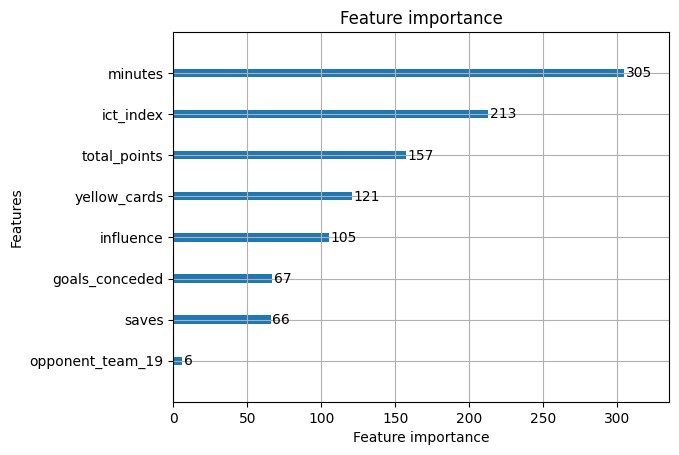

In [132]:
lightgbm.plot_importance(lgbm_estimators[0])

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

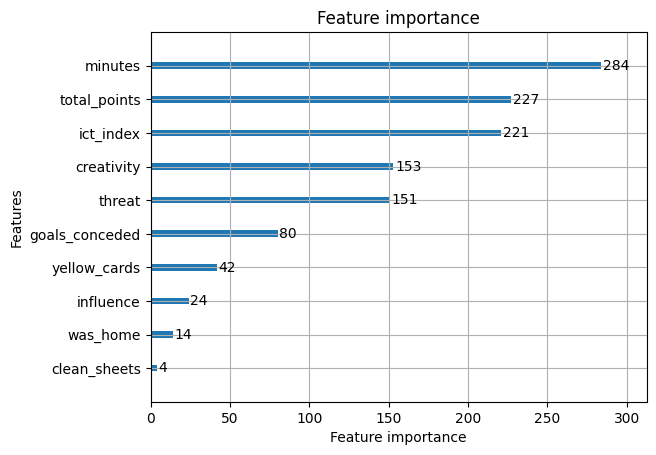

In [135]:
lightgbm.plot_importance(lgbm_estimators[3])

In [90]:
viz_df = pd.DataFrame(data={'position': names,
                         'lr_mse': [lr_results[n][1] for n in names], 
                         'lightgbm_mse': [lgbm_results[n][1] for n in names]})

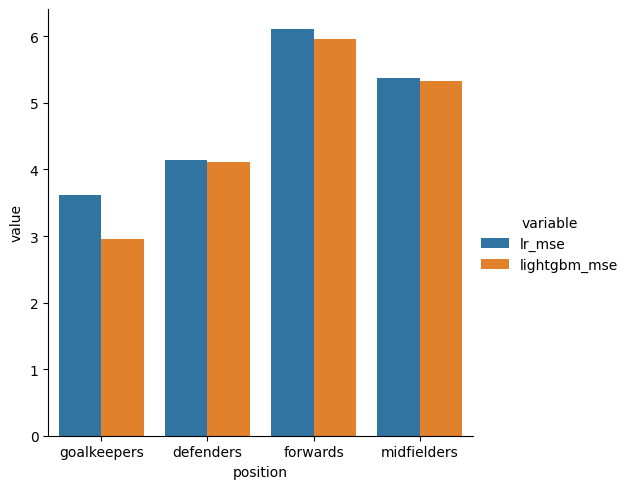

In [91]:
viz_df = pd.melt(viz_df, id_vars = 'position')
viz_df.rename(columns={'variable': 'model'})
viz_df
sns.catplot(x = 'position', y='value', hue = 'variable',data=viz_df, kind='bar')

#### Mixed Positions 

In [74]:
full_df = pd.get_dummies(full_df)

In [75]:
X = full_df.drop('Target_Output', axis=1)
y = full_df.Target_Output

# Train/Valid/Test 0.6/0.2/0.2
# Test set is still held-out and won't be used until writing the report.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [76]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(X_train, y_train)
preds = clf.predict(X_val)

train_preds = clf.predict(X_train)
print('linear Train MSE: %f' % mean_squared_error(y_train, train_preds))
print('linear Validation MSE: %f' % mean_squared_error(y_val, preds))

pd.DataFrame([clf.feature_names_in_, clf.coef_])

linear Train MSE: 4.500336
linear Validation MSE: 4.732210


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,assists,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,minutes,penalties_missed,influence,penalties_saved,...,opponent_team_19,opponent_team_2,opponent_team_20,opponent_team_3,opponent_team_4,opponent_team_5,opponent_team_6,opponent_team_7,opponent_team_8,opponent_team_9
1,-0.0,0.0,0.021234,-0.040967,-0.0,0.0,0.018807,0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
